# YOU DO NOT NEED TO RUN THE BOX THAT SAYS "generate points.csv"
## That box is only for transforming the points from the raw LIDAR data
## If you accidentally run it, just cancel the process and continue

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
import numpy as np
import laspy, lazrs
import random as random
import networkx as nx
from scipy import spatial
from pathlib import Path

In [3]:
# generate points.csv | DO NOT NEED TO RUN THIS
x_offset = -12333899.21
y_offset = 4636564.89
z_offset = 1365.4
file_path = os.path.join("map_data", "point_cloud.laz")
las = laspy.read(file_path)
points = pd.DataFrame(np.vstack((las.x, las.y, las.z)).transpose())
points.columns = ["x", "y", "z"]
for i in range (points.shape[0]):
    points.at[i, "x"] -= x_offset
    points.at[i, "y"] -= y_offset
    points.at[i, "z"] -= z_offset
# points.to_csv("points.csv", index=False)
# z is the height

sorted_points = points.sort_values(by=['x', 'y', 'z'])
sorted_points = sorted_points.reset_index(drop=True)
sorted_points.to_csv("test.csv", index=False)

In [ ]:
points = pd.read_csv("points.csv")
# randomize points.csv
points.sample(frac=1).reset_index(drop=True).to_csv("random_points.csv", index=False)
print(points.head())

      x      y      z
0  0.00  14.98  38.30
1  0.00  23.87  38.73
2  0.01  32.27  38.63
3  0.02  29.40  38.70
4  0.02  38.85  38.20


In [ ]:
points = pd.read_csv('random_points.csv')

In [293]:
# generate a random point from the "points" dataframe
minDistance = 800
start = points.loc[random.randint(0, points.shape[0])]
end = points.loc[random.randint(0, points.shape[0])]

# get the distance between two points
def distance(p1, p2):
    return math.sqrt((p1.x - p2.x)**2 + (p1.y - p2.y)**2 + (p1.z - p2.z)**2)

while (distance(start, end) < minDistance):
    start_index = random.randint(0, points.shape[0])
    end_index = random.randint(0, points.shape[0])
    start = points.loc[start_index]
    end = points.loc[end_index]

print("Start point: ", start["x"], start["y"], start["z"])
print("End point: ", end["x"], end["y"], end["z"])
print("Start index: ", str(start_index))
print("End index: ", str(end_index))

Start point:  1650.640000000596 594.2600000007078 5.2000000000000455
End point:  74.85000000149012 1030.1200000001118 46.450000000000045
Start index:  10152203
End index:  11028886


In [ ]:
# Hyperparameters

# number of edges per node in the graph
depth = 4

# number of subsets/subgraphs (ideally subsets == resolution)
subsets = 500

# higher resolution = less points. effective resolution = subsets/resolution
resolution = 5000

# heuristic function: greater return value means greater cost for the path (best path has low cost)
def heur(x1, y1, z1, x2, y2, z2):
    # if (slope_angle(x1, y1, z1, x2, y2, z2) > 45):
    #     return 10000000
    # return ((x2 - x1) ** 2 + (y2 - y1) ** 2 + (z2 - z1) ** 2) + 100 * slope_angle(x1, y1, z1, x2, y2, z2)
    return math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2 + (z2 - z1) ** 2)

# other variables
skip = len(points) // subsets
print(f"number of points per subset: {skip}")
print(f"effective resolution: {subsets/resolution}")

# plot variables
boldness = 1
plotSize = 10

# helper methods
def slope_angle(x1, y1, z1, x2, y2, z2):
    if ((x2 - x1) ** 2 + (y2 - y1) ** 2 <= 0.0001 and z2 - z1 > 0):
        return 90
    return math.degrees(math.atan(abs(z2 - z1) / math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)))

number of points per subset: 22324
effective resolution: 0.1


In [ ]:
skip = len(points) // subsets  # Number of points per subset
points_per_subset = len(points) // resolution  # Number of points per subset based on resolution

output_dir = Path("subsets")
output_dir.mkdir(exist_ok=True)

for i in range(subsets):
    # Select the subset of points with points_per_subset points
    sub = points.iloc[i * points_per_subset:(i + 1) * points_per_subset].copy()
    
    # Add the start and end points to the subset
    sub = pd.concat([sub, start.to_frame().T, end.to_frame().T], ignore_index=True)
    
    # Save the subset to a CSV file
    filepath = output_dir / f"sub{i}.csv"
    sub.to_csv(filepath, index=False)

print(f"{subsets} subsets saved to {filepath}")

Subset 0 saved to subsets/sub0.csv
Subset 1 saved to subsets/sub1.csv
Subset 2 saved to subsets/sub2.csv
Subset 3 saved to subsets/sub3.csv
Subset 4 saved to subsets/sub4.csv
Subset 5 saved to subsets/sub5.csv
Subset 6 saved to subsets/sub6.csv
Subset 7 saved to subsets/sub7.csv
Subset 8 saved to subsets/sub8.csv
Subset 9 saved to subsets/sub9.csv
Subset 10 saved to subsets/sub10.csv
Subset 11 saved to subsets/sub11.csv
Subset 12 saved to subsets/sub12.csv
Subset 13 saved to subsets/sub13.csv
Subset 14 saved to subsets/sub14.csv
Subset 15 saved to subsets/sub15.csv
Subset 16 saved to subsets/sub16.csv
Subset 17 saved to subsets/sub17.csv
Subset 18 saved to subsets/sub18.csv
Subset 19 saved to subsets/sub19.csv
Subset 20 saved to subsets/sub20.csv
Subset 21 saved to subsets/sub21.csv
Subset 22 saved to subsets/sub22.csv
Subset 23 saved to subsets/sub23.csv
Subset 24 saved to subsets/sub24.csv
Subset 25 saved to subsets/sub25.csv
Subset 26 saved to subsets/sub26.csv
Subset 27 saved to su

In [ ]:
path_points = pd.DataFrame(columns=["x", "y", "z"])
path_points = path_points._append(start)
# Define the heuristic function for A*
def heuristic1(node1, node2):
    x1, y1, z1 = G.nodes[node1]['x'], G.nodes[node1]['y'], G.nodes[node1]['z']
    x2, y2, z2 = G.nodes[node2]['x'], G.nodes[node2]['y'], G.nodes[node2]['z']
    return heur(x1, y1, z1, x2, y2, z2)

for k in range(subsets):
    print(f"Starting subset {k}")
    sub = pd.read_csv(os.path.join("subsets", f"sub{k}.csv"))

    G = nx.Graph()

    print(f"Adding nodes and edges for subset {k}")
    # Add nodes from subset
    for i, row in sub.iterrows():
        G.add_node(i, x = row['x'], y = row['y'], z = row['z'])

    print(f"Making edges {k}")
    # Add edges between the closest nodes (ignoring height)
    coords = sub[['x', 'y']].values
    tree = spatial.KDTree(coords)
    for i, row in sub.iterrows():
        distances, indices = tree.query([row['x'], row['y']], k=depth+1)
        for j in range(1, len(indices)):  # skip the first index because it is the point itself
            G.add_edge(i, indices[j], weight=distances[j])

    # check if the graph is connected
    if not nx.is_connected(G):
        print(f"Subset {k} is not connected. Adding edges to connect the graph")
        # start at a node. add an edge to the closest node that is not connected
        # repeat until the graph is connected
        start_node = sub.shape[0] - 2
        end_node = sub.shape[0] - 1
        while not nx.has_path(G, start_node, end_node):
            # find the closest node that is not connected
            for i, row in sub.iterrows():
                if not nx.has_path(G, start_node, i):
                    w = math.sqrt((sub.loc[start_node, 'x'] - sub.loc[i, 'x'])**2 + (sub.loc[start_node, 'y'] - sub.loc[i, 'y'])**2)
                    G.add_edge(start_node, i, weight=w)
                    break

    print(f"Finding path for subset {k}")
    # Find the shortest path using A*
    path = nx.astar_path(G, sub.shape[0] - 2, sub.shape[0] - 1, heuristic=heuristic1)
    path = pd.Series(path)
    
    # add path to path_points
    path_points = pd.concat([path_points, sub.loc[path]])
    print(f"Finished subset {k}\n")

print("Done")

/var/folders/nj/3217hbg559b0blsl1jfx56tw0000gn/T/ipykernel_71559/901273278.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  path_points = path_points._append(start)


Starting subset 0
Adding nodes and edges for subset 0
Making edges 0
Subset 0 is not connected. Adding edges to connect the graph
Finding path for subset 0
Finished subset 0

Starting subset 1
Adding nodes and edges for subset 1
Making edges 1
Finding path for subset 1
Finished subset 1

Starting subset 2
Adding nodes and edges for subset 2
Making edges 2
Finding path for subset 2
Finished subset 2

Starting subset 3
Adding nodes and edges for subset 3
Making edges 3
Subset 3 is not connected. Adding edges to connect the graph
Finding path for subset 3
Finished subset 3

Starting subset 4
Adding nodes and edges for subset 4
Making edges 4
Finding path for subset 4
Finished subset 4

Starting subset 5
Adding nodes and edges for subset 5
Making edges 5
Finding path for subset 5
Finished subset 5

Starting subset 6
Adding nodes and edges for subset 6
Making edges 6
Finding path for subset 6
Finished subset 6

Starting subset 7
Adding nodes and edges for subset 7
Making edges 7
Finding pat

In [316]:
path_points.drop_duplicates(inplace=True, keep='first')
path_points.reset_index(drop=True, inplace=True)
# add end point to path_points
path_points = path_points._append(end, ignore_index=True)
print(path_points)

             x        y      z
0      1650.64   594.26   5.20
1      1601.72   611.10   4.67
2      1575.56   639.33   4.36
3      1542.51   642.24   5.48
4      1515.53   653.23   5.83
...        ...      ...    ...
33824   108.86   945.09  44.77
33825    91.79   949.93  43.82
33826    67.05   961.95  44.88
33827    60.38   997.69  45.87
33828    74.85  1030.12  46.45

[33829 rows x 3 columns]


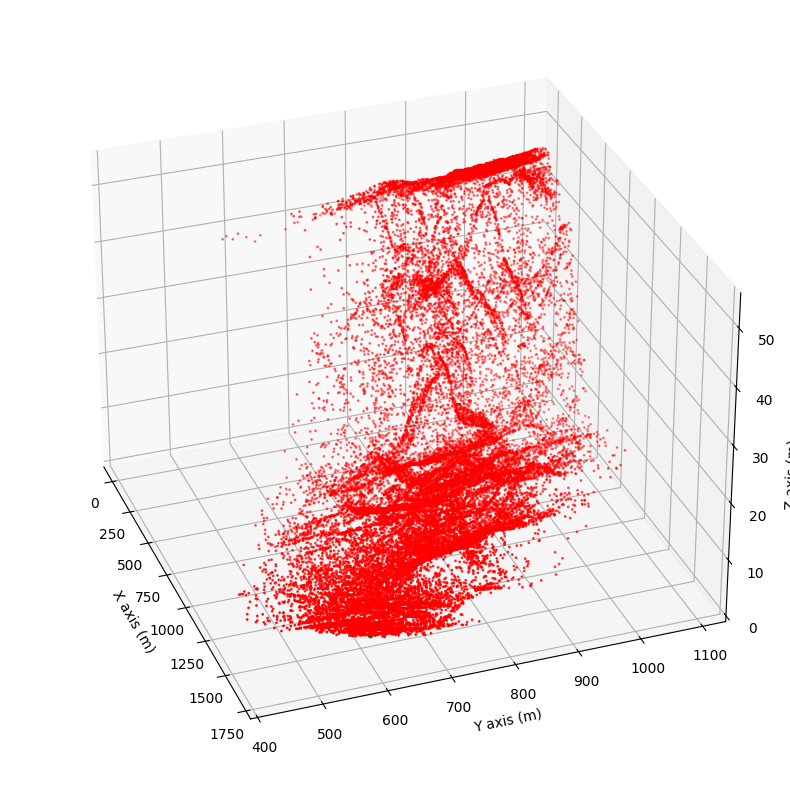

In [317]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(path_points["x"], path_points["y"], path_points["z"], c='r', s=boldness)

# plot start and end points
ax.scatter(start["x"], start["y"], start["z"], c='g', s=boldness*10)
ax.scatter(end["x"], end["y"], end["z"], c='b', s=boldness*10)

ax.set_xlabel('X axis (m)')
ax.set_ylabel('Y axis (m)')
ax.set_zlabel('Z axis (m)')
plt.rcParams["figure.figsize"] = (plotSize, plotSize)
ax.view_init(elev=30, azim=-20)
plt.show()

In [ ]:
print("Finding path for path_points")
# make new graph using path_points
G = nx.Graph()

# Add nodes from path_points
for i, row in path_points.iterrows():
    G.add_node(i, x = row['x'], y = row['y'], z = row['z'])

# Add edges between the closest nodes
coords = path_points[['x', 'y', 'z']].values
tree = spatial.KDTree(coords)
for i, row in path_points.iterrows():
    distances, indices = tree.query([row['x'], row['y'], row['z']], k=depth+1)
    for j in range(1, len(indices)):  # skip the first index because it is the point itself
        G.add_edge(i, indices[j], weight=distances[j])

# Define the heuristic function for A*
def heuristic2(node1, node2):
    x1, y1, z1 = G.nodes[node1]['x'], G.nodes[node1]['y'], G.nodes[node1]['z']
    x2, y2, z2 = G.nodes[node2]['x'], G.nodes[node2]['y'], G.nodes[node2]['z']
    return heur(x1, y1, z1, x2, y2, z2)

# check if the graph is connected
if not nx.is_connected(G):
    print(f"Subset {k} is not connected. Adding edges to connect the graph")
    # start at a node. add an edge to the closest node that is not connected
    # repeat until the graph is connected
    start_node = sub.shape[0] - 2
    end_node = sub.shape[0] - 1
    while not nx.has_path(G, start_node, end_node):
        # find the closest node that is not connected
        for i, row in sub.iterrows():
            if not nx.has_path(G, start_node, i):
                w = math.sqrt((sub.loc[start_node, 'x'] - sub.loc[i, 'x'])**2 + (sub.loc[start_node, 'y'] - sub.loc[i, 'y'])**2)
                G.add_edge(start_node, i, weight=w)
                break

# Find the shortest path using A*
path = nx.astar_path(G, 0, path_points.shape[0] - 1, heuristic=heuristic2)
path = pd.Series(path)
print("Done")

Finding path for path_points
The graph is not connected
Done


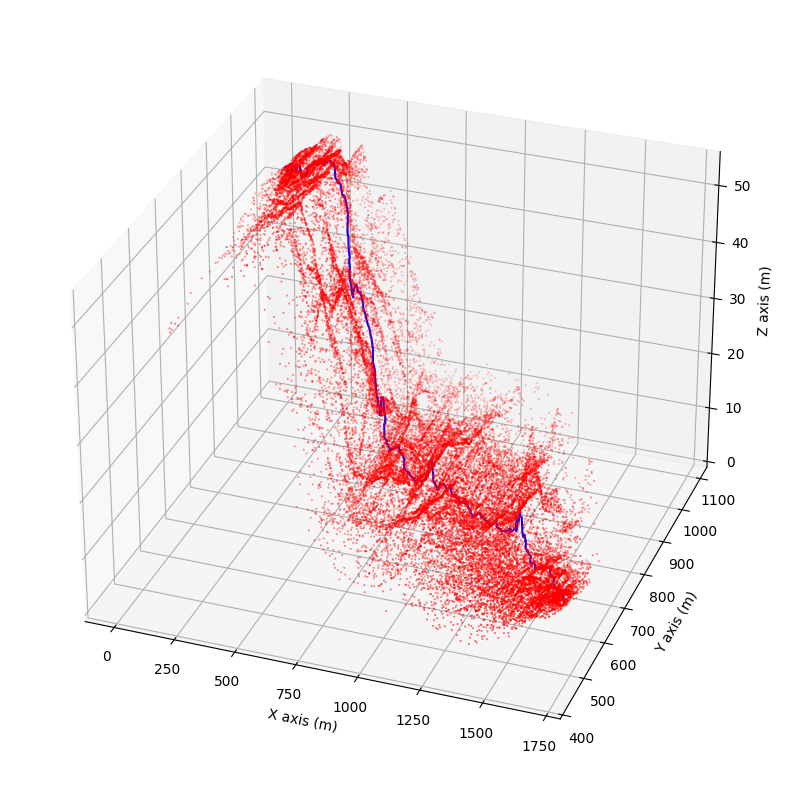

In [324]:
# plot the path
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(path_points["x"], path_points["y"], path_points["z"], c='r', s=boldness/10)
ax.plot(path_points.loc[path]["x"], path_points.loc[path]["y"], path_points.loc[path]["z"], c='b')
ax.set_xlabel('X axis (m)')
ax.set_ylabel('Y axis (m)')
ax.set_zlabel('Z axis (m)')
plt.rcParams["figure.figsize"] = (plotSize, plotSize)
ax.view_init(elev=30, azim=-70)
plt.show()

In [325]:
# print the weight of each edge in the path
total_weight = 0
for i in range(len(path) - 1):
    total_weight += G[path[i]][path[i+1]]['weight']
    print(f"Edge {i}: {G[path[i]][path[i+1]]['weight']}")

Edge 0: 5.970535990010145
Edge 1: 2.3761523515083276
Edge 2: 2.044040116774373
Edge 3: 3.111173411875485
Edge 4: 3.6304407444266307
Edge 5: 3.439956395457568
Edge 6: 1.767936650462246
Edge 7: 1.1661046256250676
Edge 8: 2.924893161585041
Edge 9: 2.536493642295531
Edge 10: 2.3789073123848135
Edge 11: 2.331115612892354
Edge 12: 3.1370208787069784
Edge 13: 3.0088868372479074
Edge 14: 2.4989998009226086
Edge 15: 2.2863508032526676
Edge 16: 2.8493683520444772
Edge 17: 2.2765763765411484
Edge 18: 2.272135559499172
Edge 19: 2.23089668070134
Edge 20: 2.837340304251126
Edge 21: 2.070024154745385
Edge 22: 2.805334203343491
Edge 23: 1.4021768792871927
Edge 24: 2.6893865469102107
Edge 25: 2.322089577558079
Edge 26: 2.0905980006844085
Edge 27: 1.5133076348306382
Edge 28: 2.5267766027868657
Edge 29: 1.5754047096123287
Edge 30: 2.165640783146456
Edge 31: 2.54923517911137
Edge 32: 2.183597947455449
Edge 33: 2.4357955577956716
Edge 34: 3.3345764354177474
Edge 35: 3.2139228358383978
Edge 36: 3.0721490855